In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "png2x"

from __future__ import print_function

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Degrading a Spectrum to Lower Resolution



In [3]:
import coronagraph as cg
print(cg.__version__)

0.1


### Proxima Centauri Stellar Spectrum

First, let's grab the stellar spectral energy distribution (SED) of Proxima Centauri from the VPL website: 

In [4]:
# The file is located at the following URL:
url = "http://vpl.astro.washington.edu/spectra/stellar/proxima_cen_sed.txt"

# We can open the URL with the following 
import urllib.request
response = urllib.request.urlopen(url)

# Read file lines
data = response.readlines()

# Remove header and extraneous info
tmp = np.array([np.array(str(d).split("\\")) for d in data[25:]])[:,[1,2]]

# Extract columns
lam = np.array([float(d[1:]) for d in tmp[:,0]])
flux = np.array([float(d[1:]) for d in tmp[:,1]])

Now let's set the min and max for our low res wavelength grid, use `construct_lam` to create the low-res wavelength grid, use `downbin_spec` to make a low-res spectrum, and plot it. 

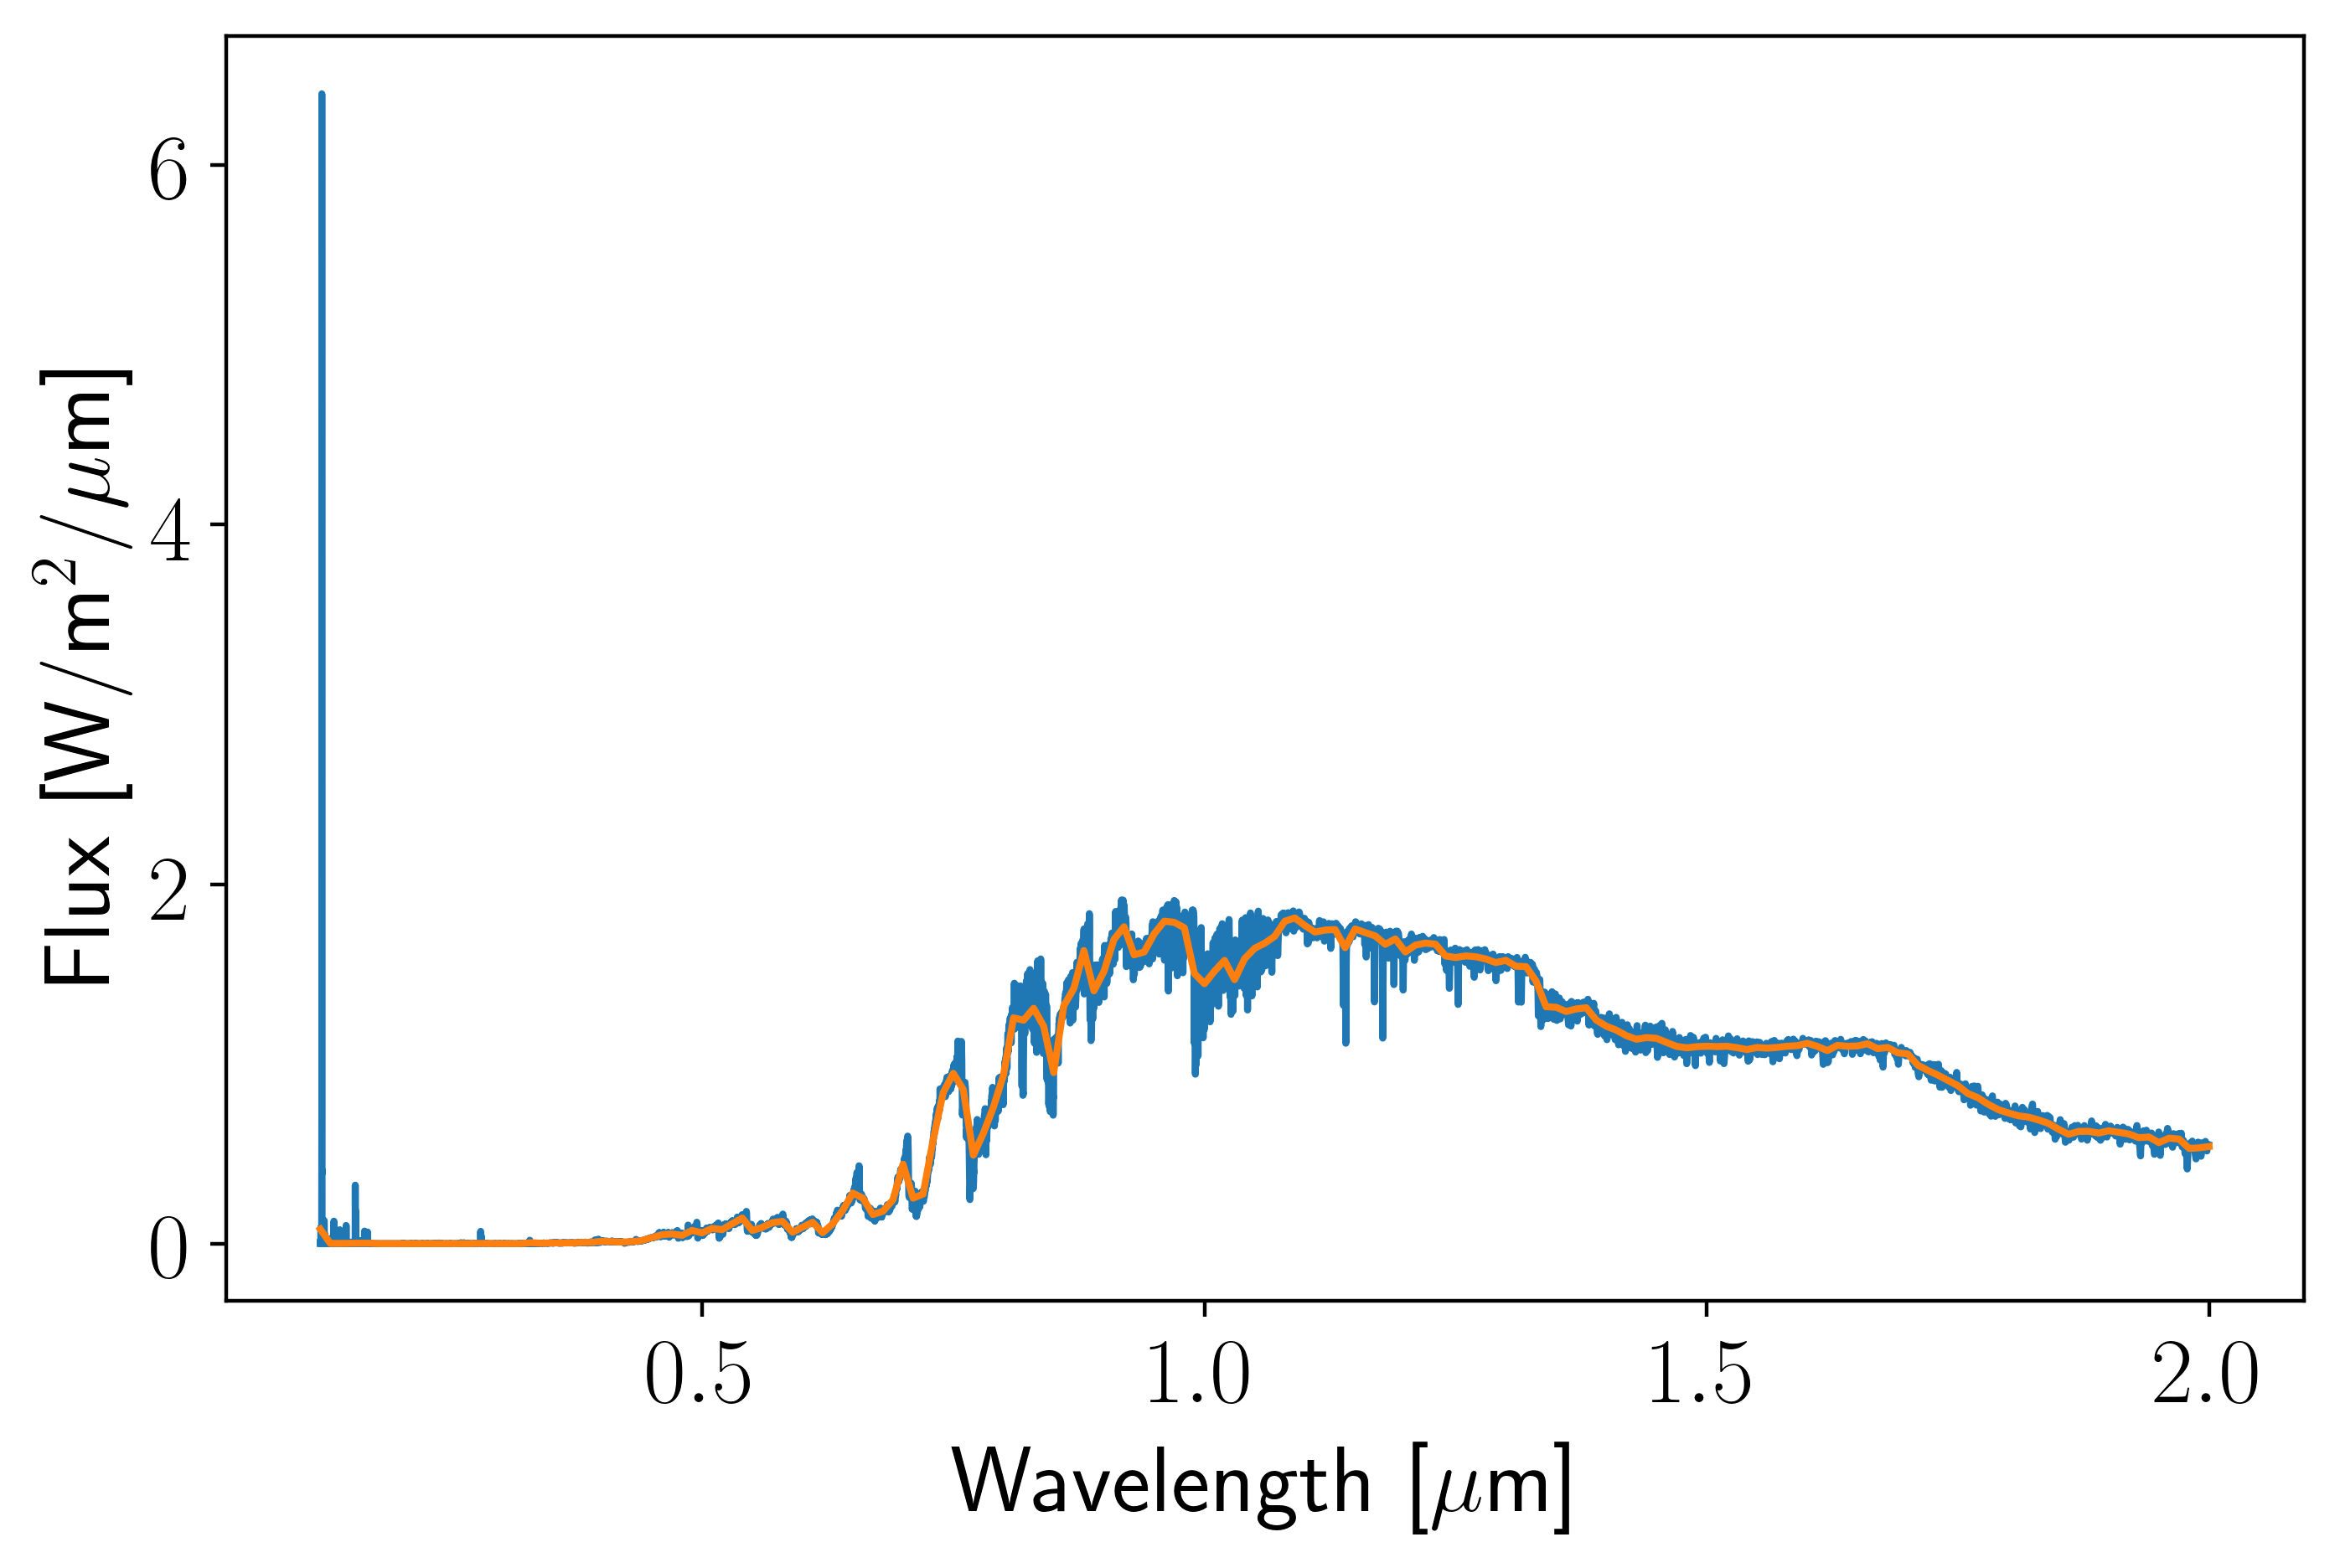

In [5]:
# Set the wavelength and resolution parameters
lammin = 0.12
lammax = 2.0
R = 200
dl = 0.01

# Construct new low-res wavelength grid
wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, dlam = dl)

# Down-bin flux to low-res
flr = cg.downbin_spec(flux, lam, wl, dlam=dwl)

# Plot
m = (lam > lammin) & (lam < lammax)
plt.plot(lam[m], flux[m])
plt.plot(wl, flr)
#plt.yscale("log")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Flux [W/m$^2$/$\mu$m]");

NaNs can occur when no high-resolution values exist within a given lower-resolution bein. How many NaNs are there?

In [6]:
print(np.sum(~np.isfinite(flr)))

0


Let's try it again now focusing on the UV with a higher resolution.

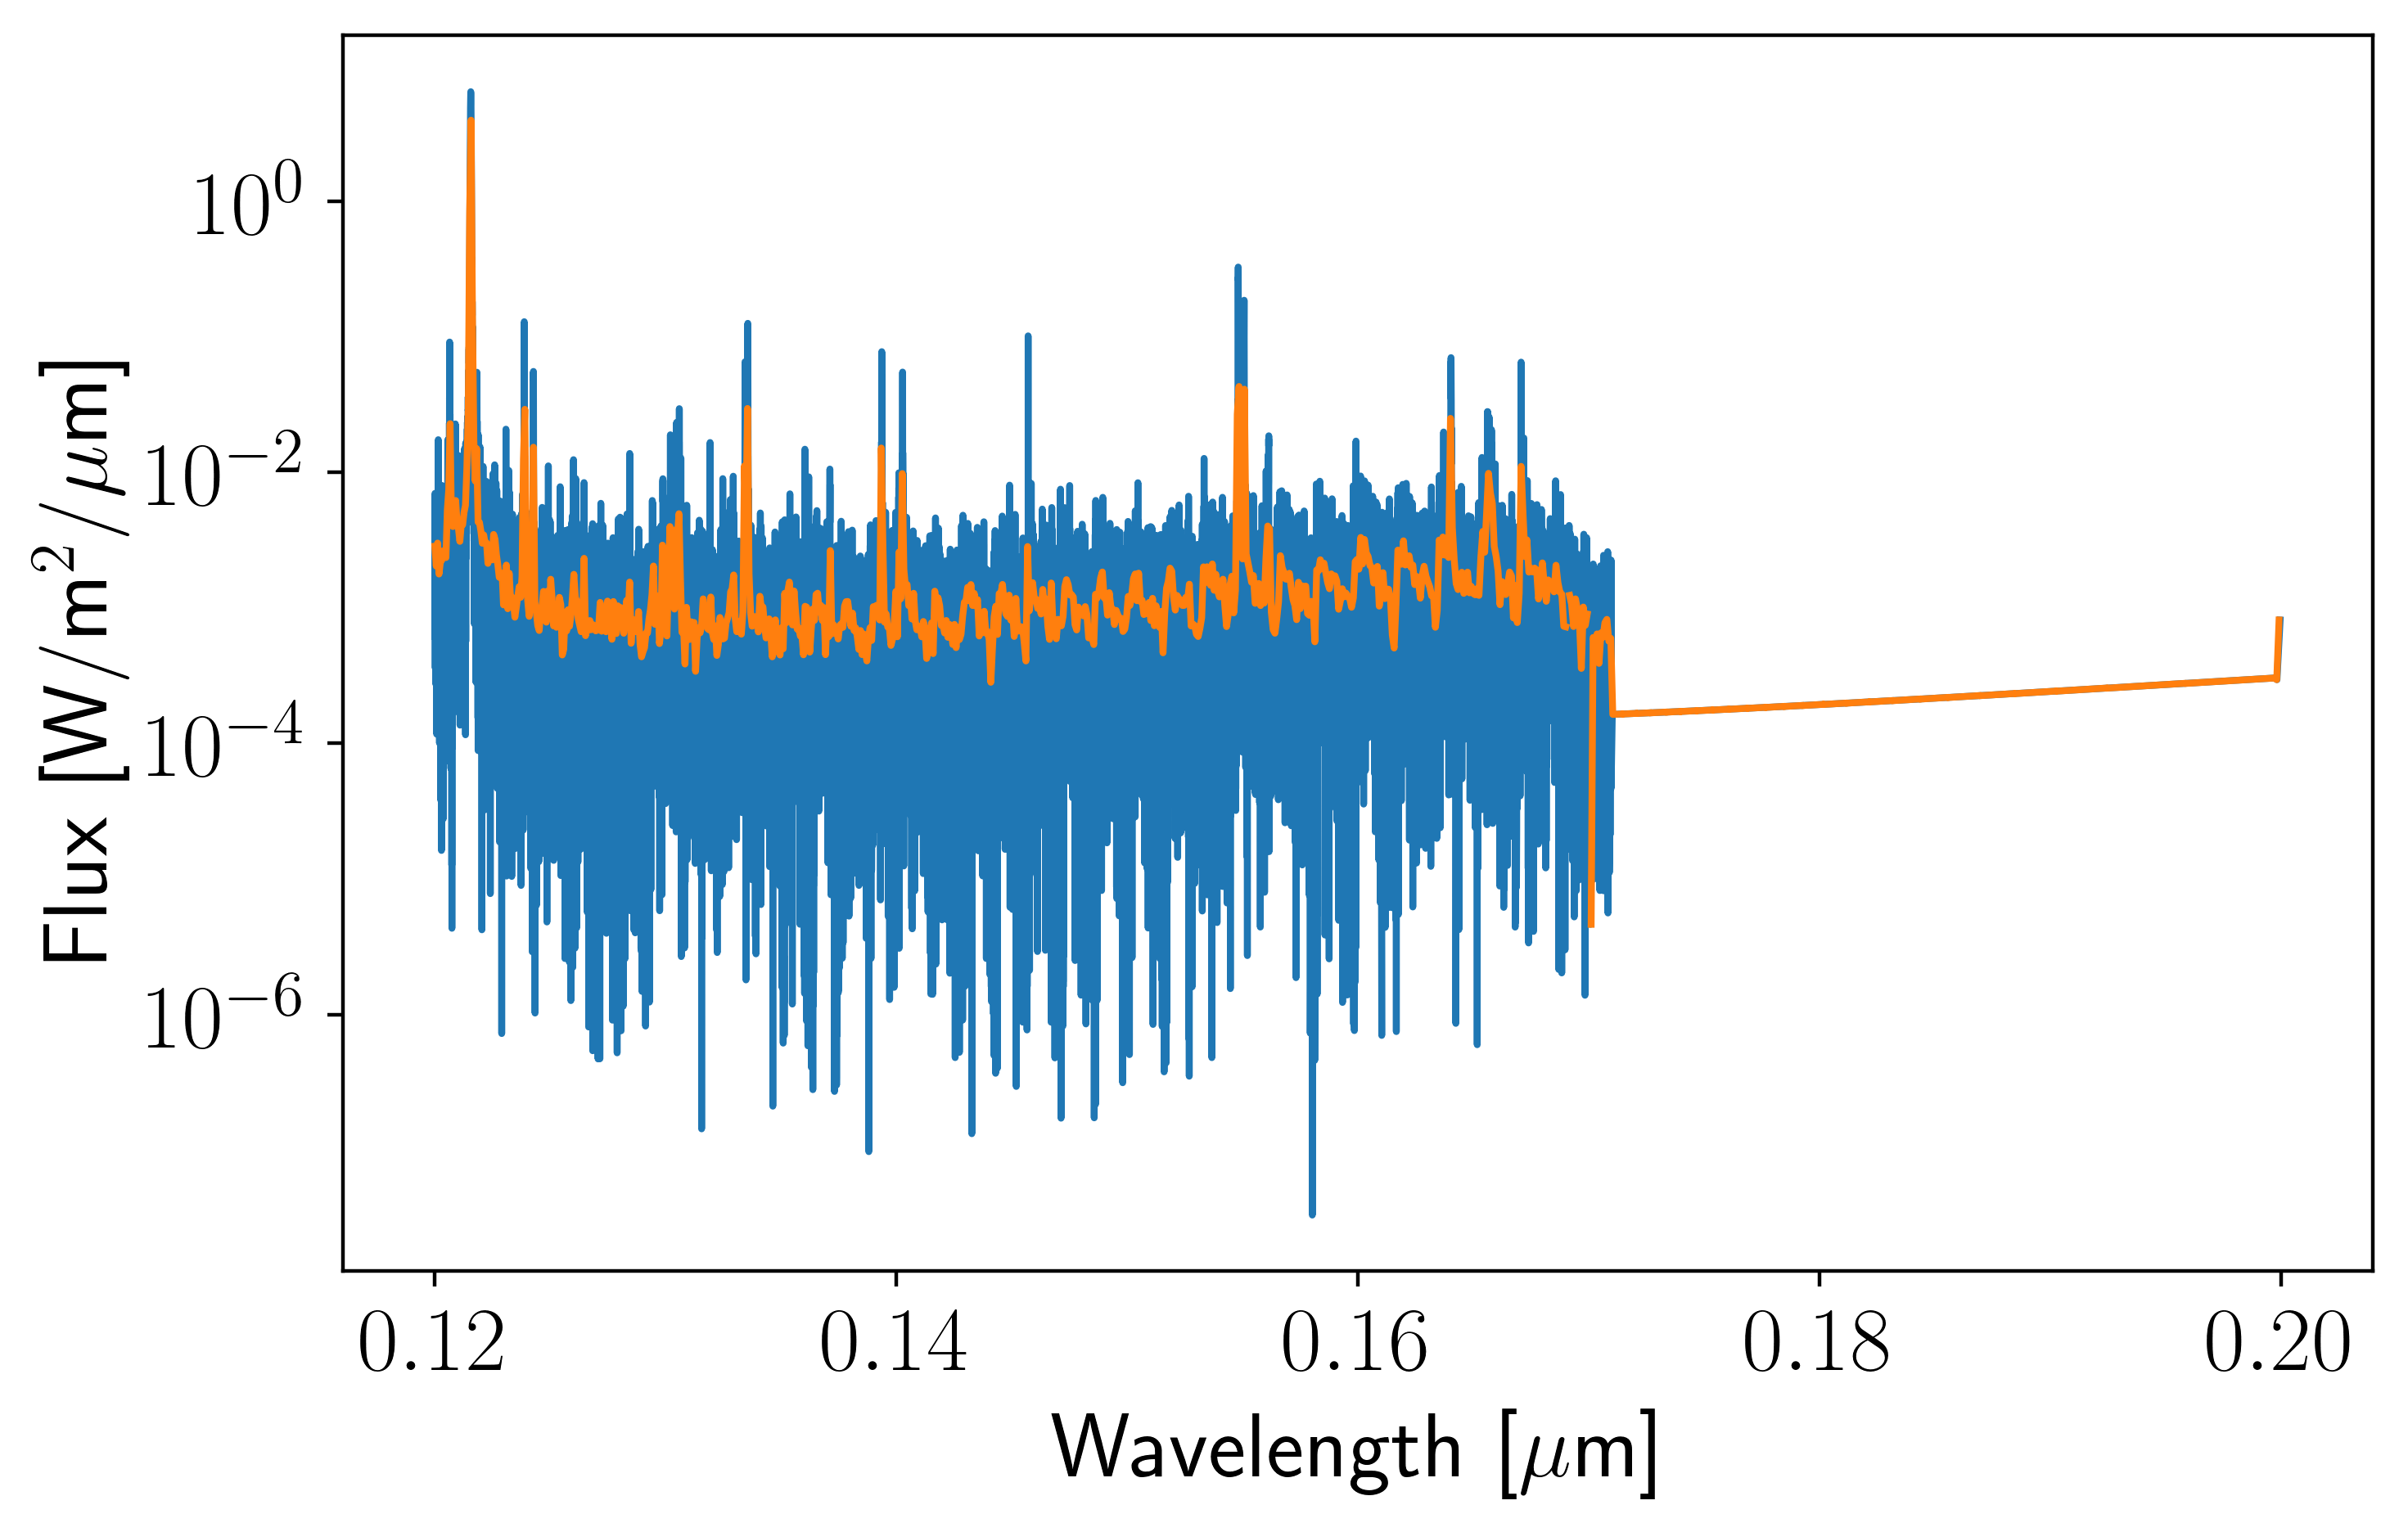

In [7]:
# Set the wavelength and resolution parameters
lammin = 0.12
lammax = 0.2
R = 2000

# Construct new low-res wavelength grid
wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, R)

# Down-bin flux to low-res
flr = cg.downbin_spec(flux, lam, wl, dlam=dwl)

# Plot
m = (lam > lammin) & (lam < lammax)
plt.plot(lam[m], flux[m])
plt.plot(wl, flr)
plt.yscale("log")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel(r"Flux [W/m$^2$/$\mu$m]");

In [8]:
print(np.sum(~np.isfinite(flr)))

26


### Optimal Resolution for Observing Earth's O$_2$ A-band  

Let's load in the Earth's reflectance spectrum [(Robinson et al., 2011)](http://adsabs.harvard.edu/abs/2011AsBio..11..393R).

In [9]:
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

Now let's isolate just the O$_2$ A-band.

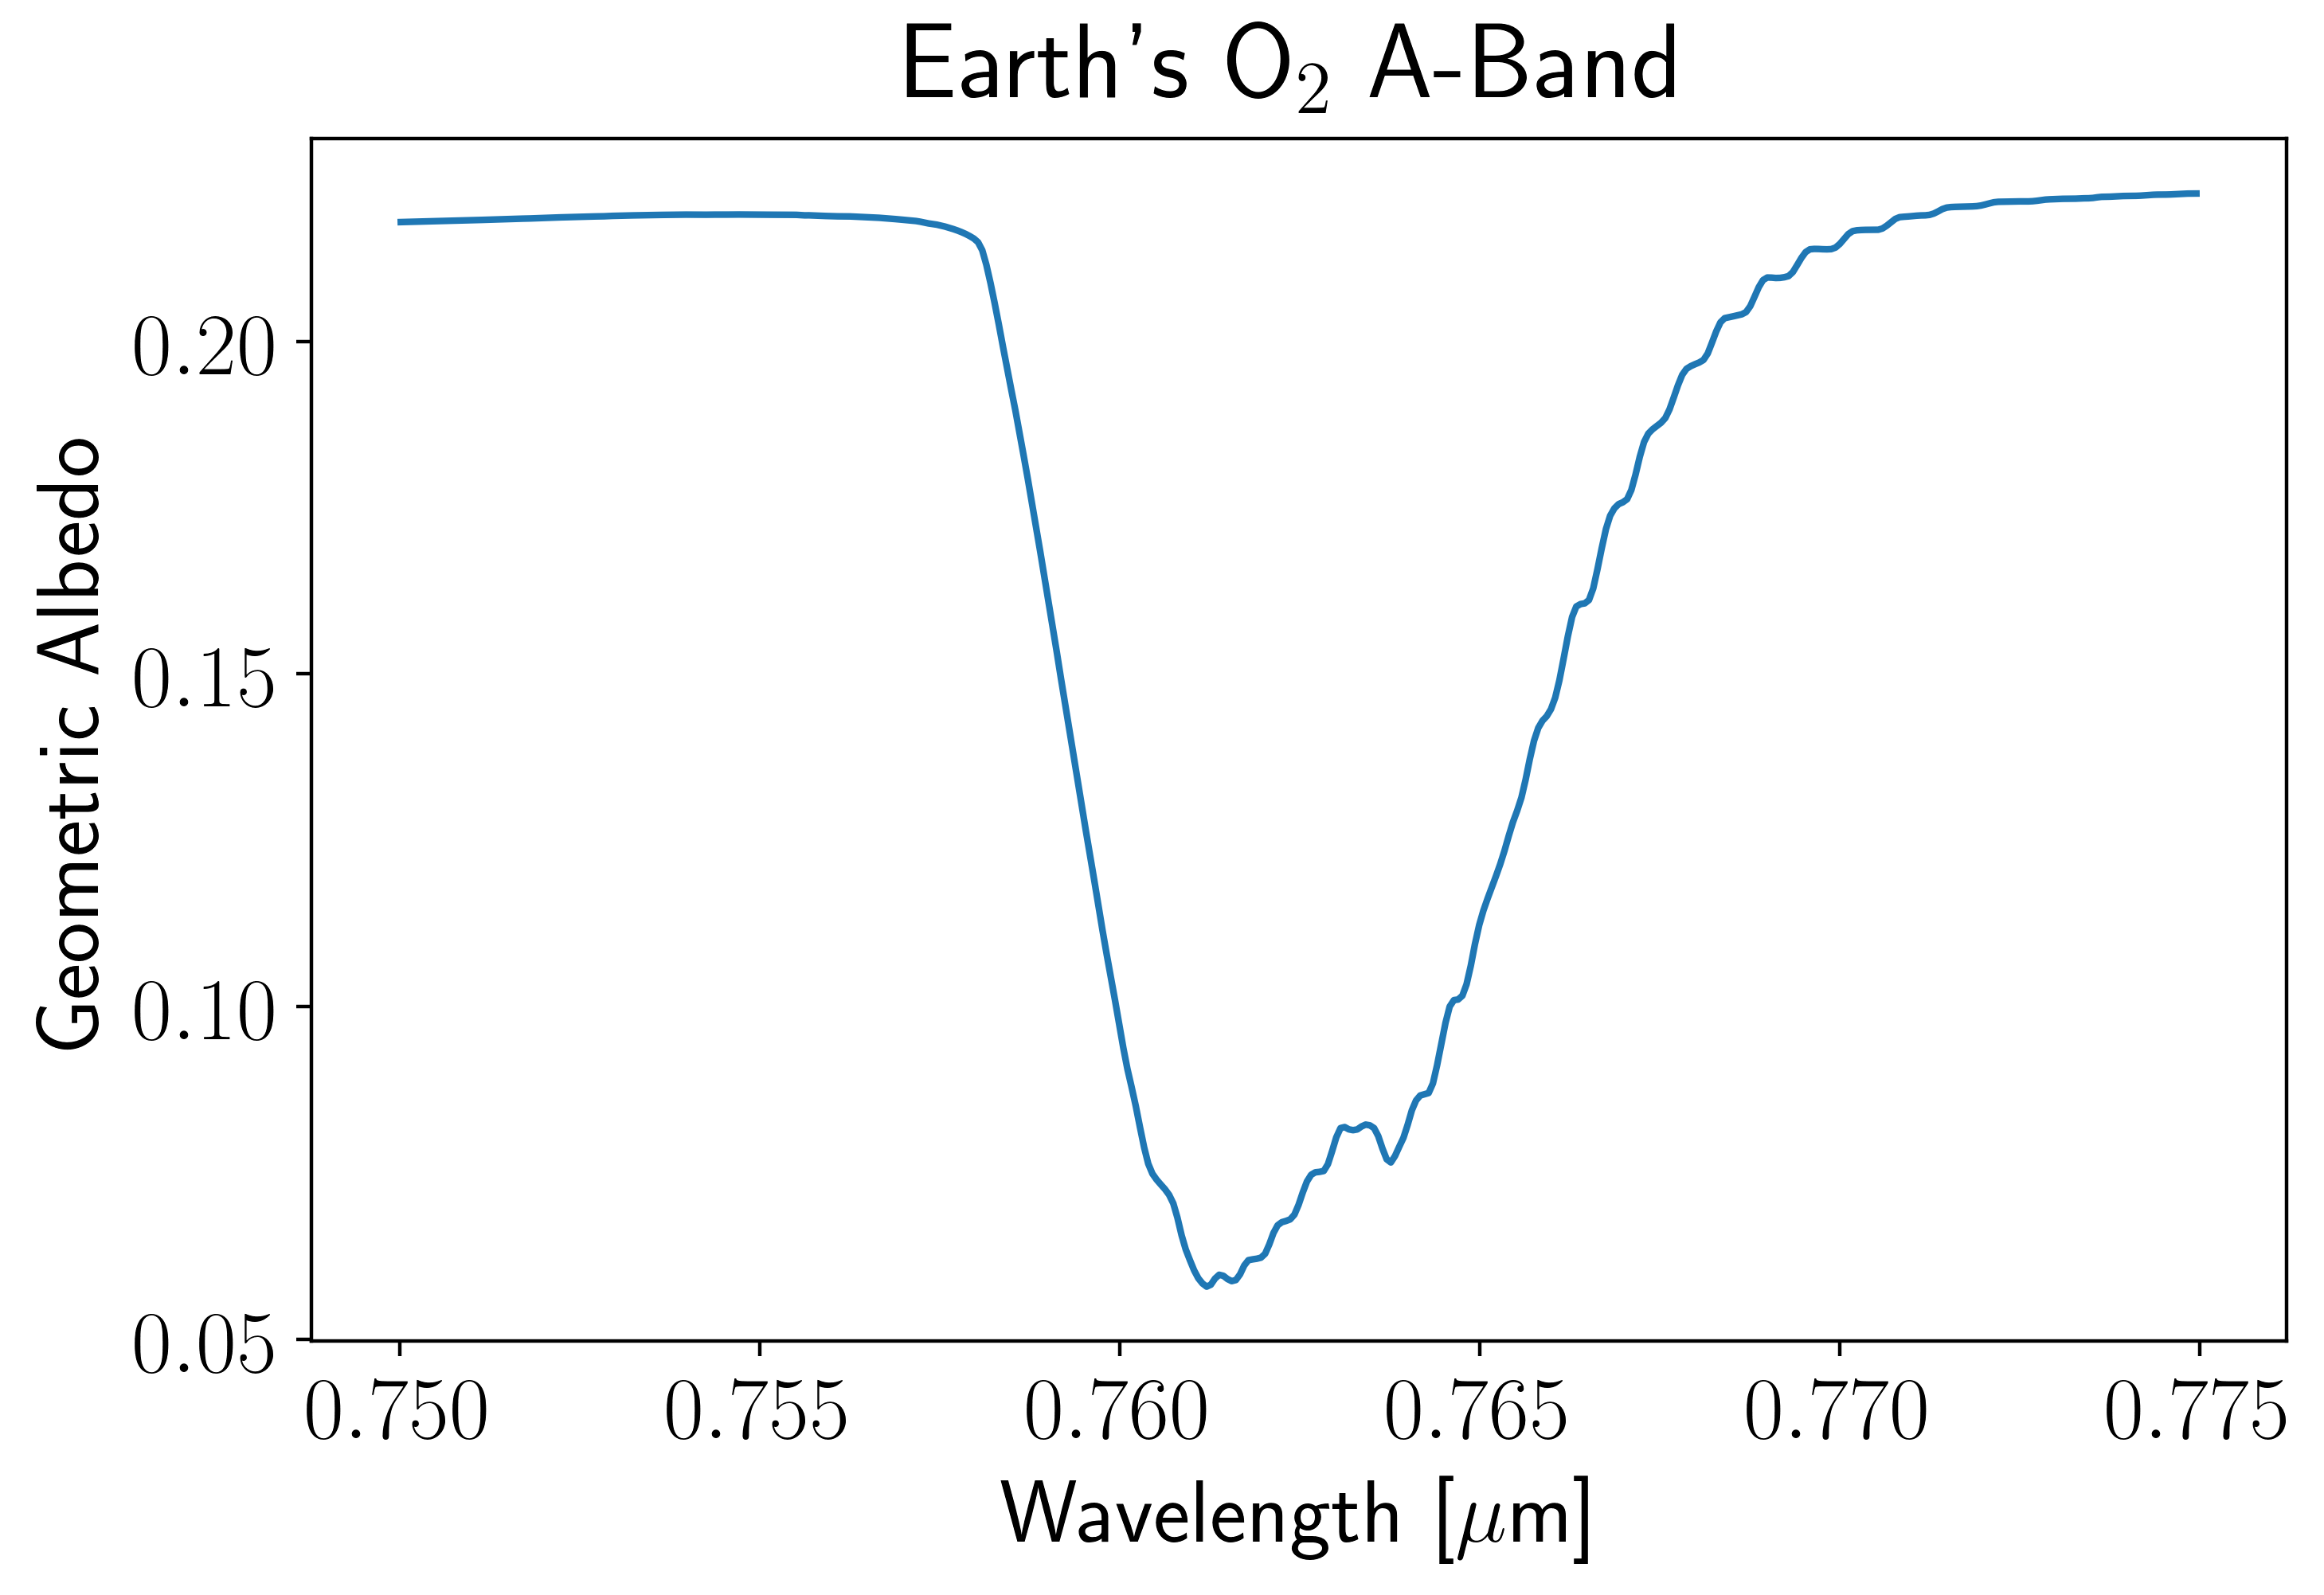

In [10]:
lammin = 0.750
lammax = 0.775

# Create a wavelength mask
m = (lamhr > lammin) & (lamhr < lammax)

# Plot the band
plt.plot(lamhr[m], Ahr[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

Define a set of resolving powers for us to loop over.

In [11]:
R = np.array([1, 10, 30, 70, 100, 150, 200, 500, 1000])

Let's down-bin the high-res spectrum at each `R`. For each `R` in the loop we will construct a new wavelength grid, down-bin the high-res spectrum, and plot the degraded spectrum. Let's also save the minimum value in the degraded spectrum to assess how close we get to the actual bottom of the band.  

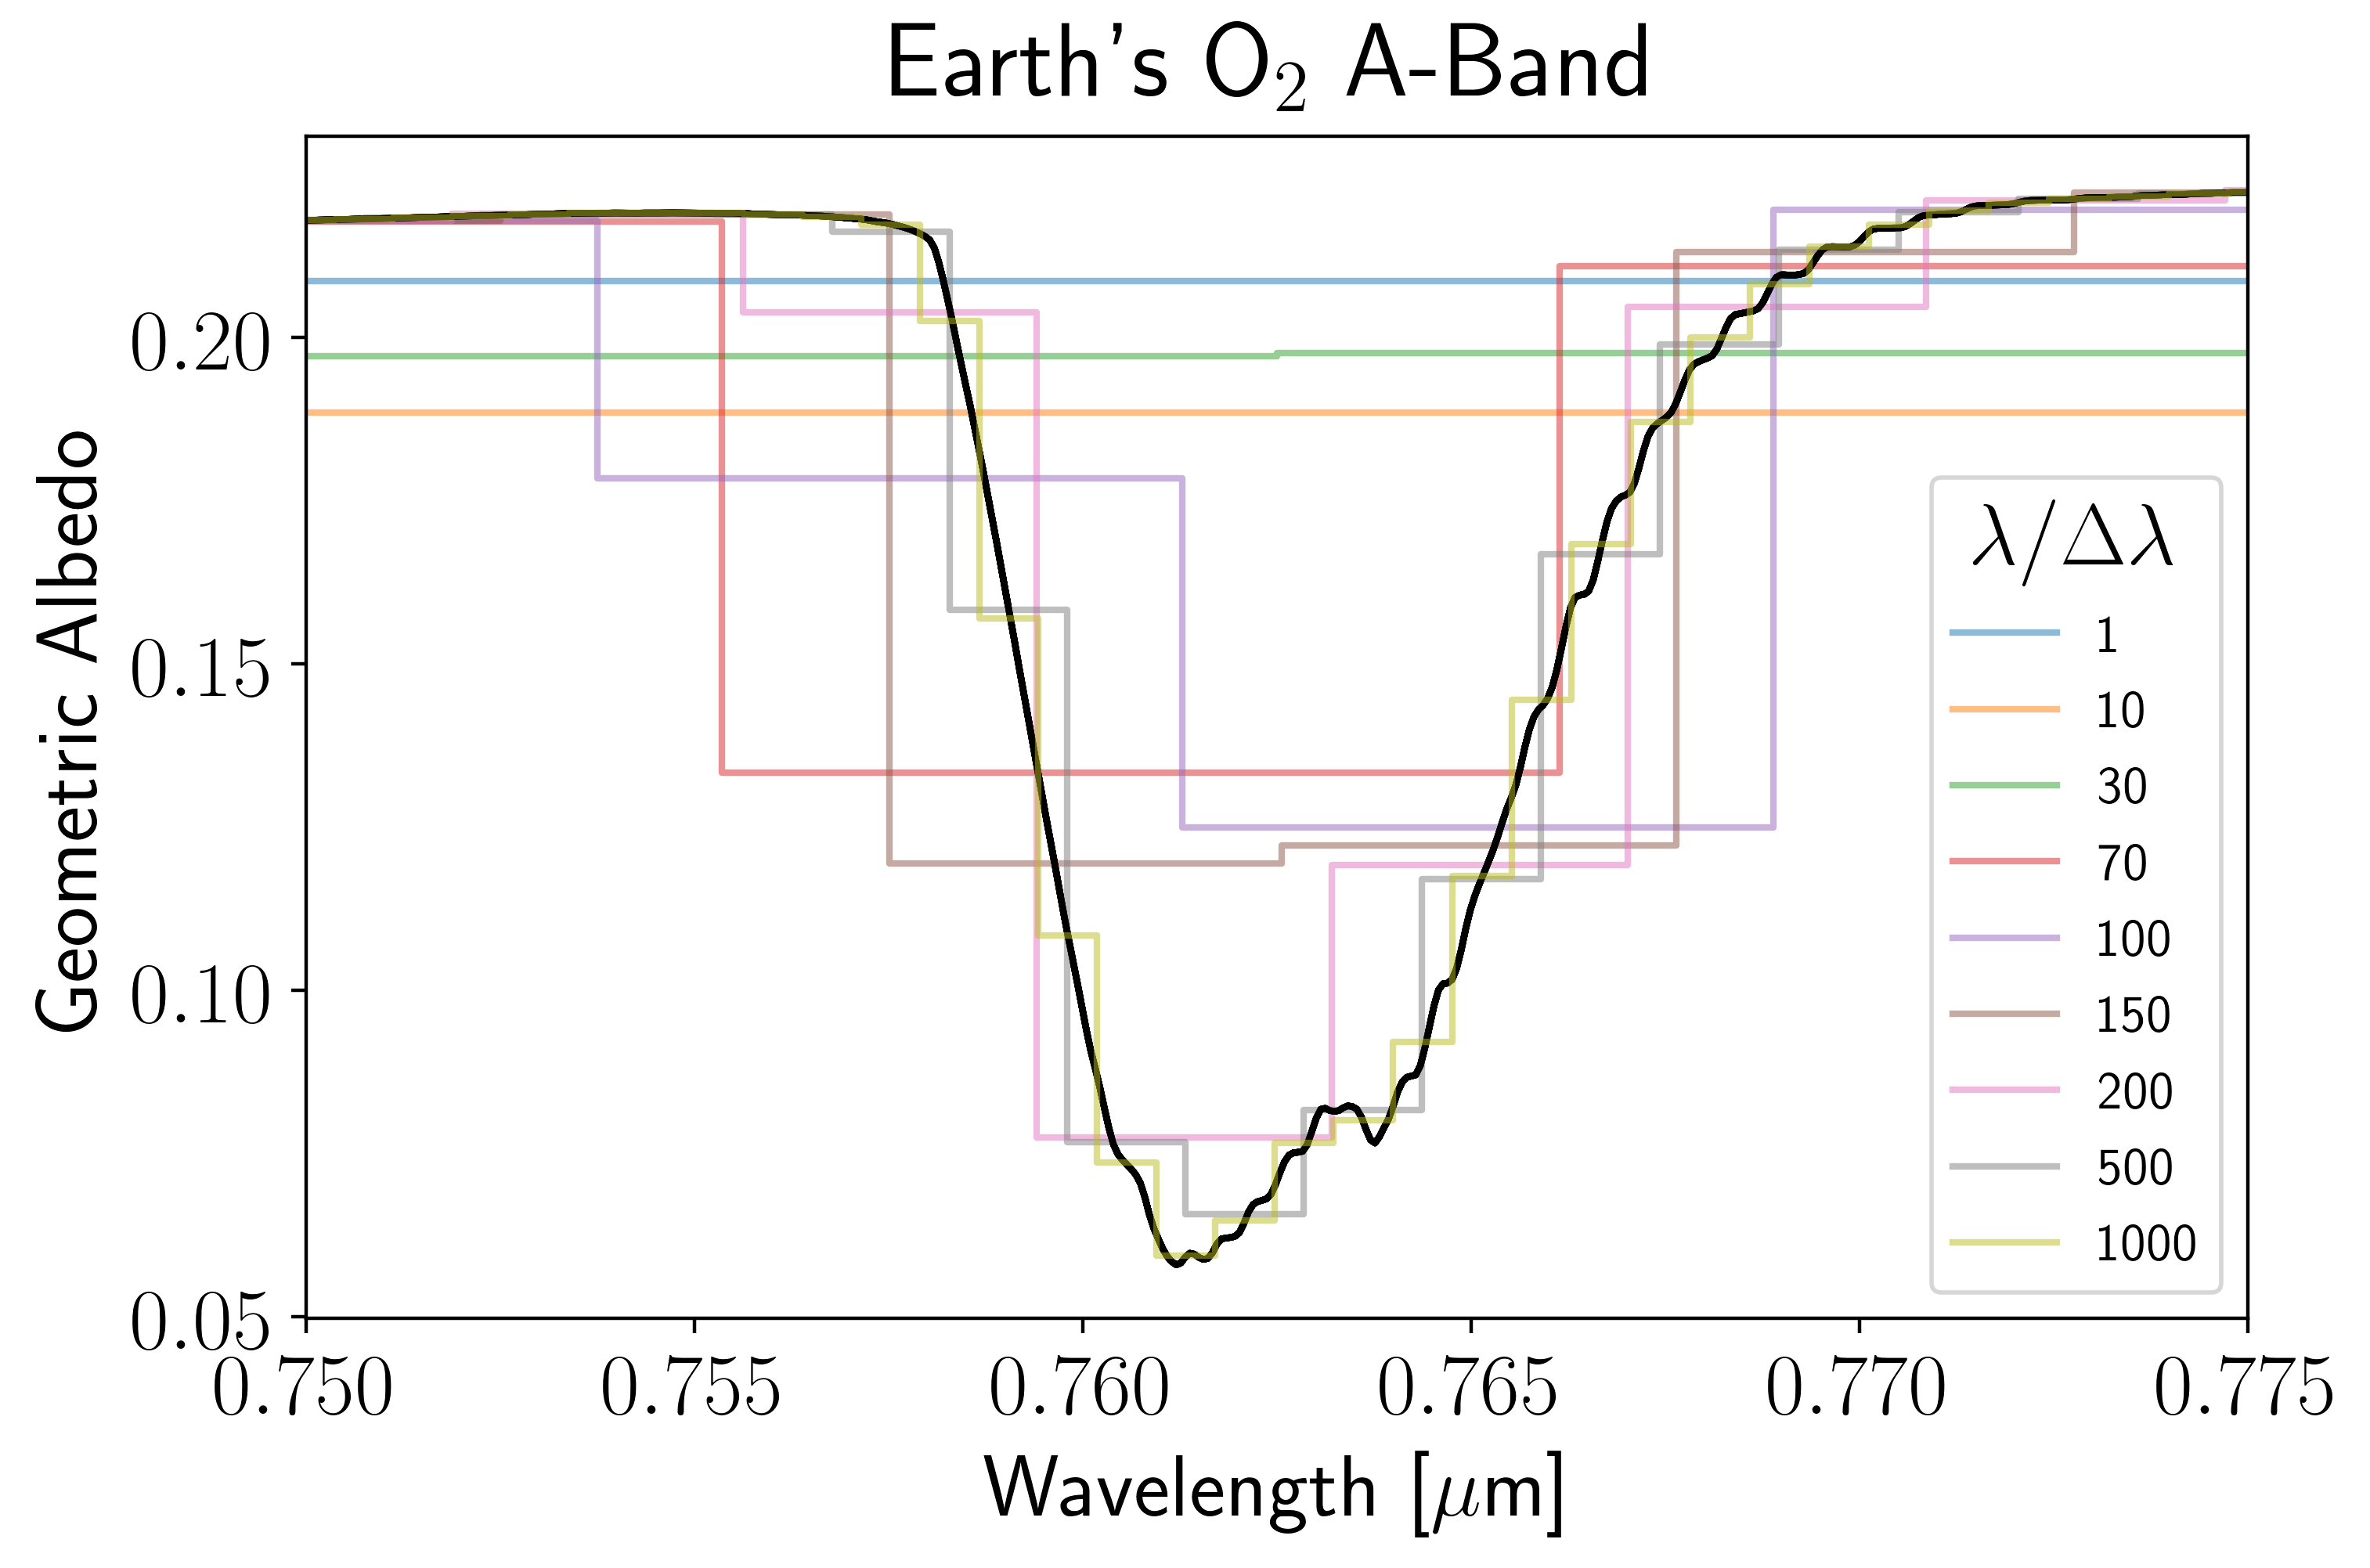

In [12]:
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R):
    
    # Construct new low-res wavelength grid
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, r)

    # Down-bin flux to low-res
    Alr = cg.downbin_spec(Ahr, lamhr, wl, dlam=dwl)
    
    # Plot 
    plt.plot(lamhr[m], Ahr[m], c = "k")
    plt.plot(wl, Alr, ls = "steps-mid", alpha = 0.5, label = "%i" %r)
    plt.xlim(lammin, lammax)
    
    # Save bottom value
    bottom_val[i] = np.min(Alr)

# Finsh plot
plt.legend(fontsize = 12, title = r"$\lambda / \Delta \lambda$")
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title(r"Earth's O$_2$ A-Band");

We can now compare the bottom value in low-res spectra to the bottom of the high-res spectrum.  

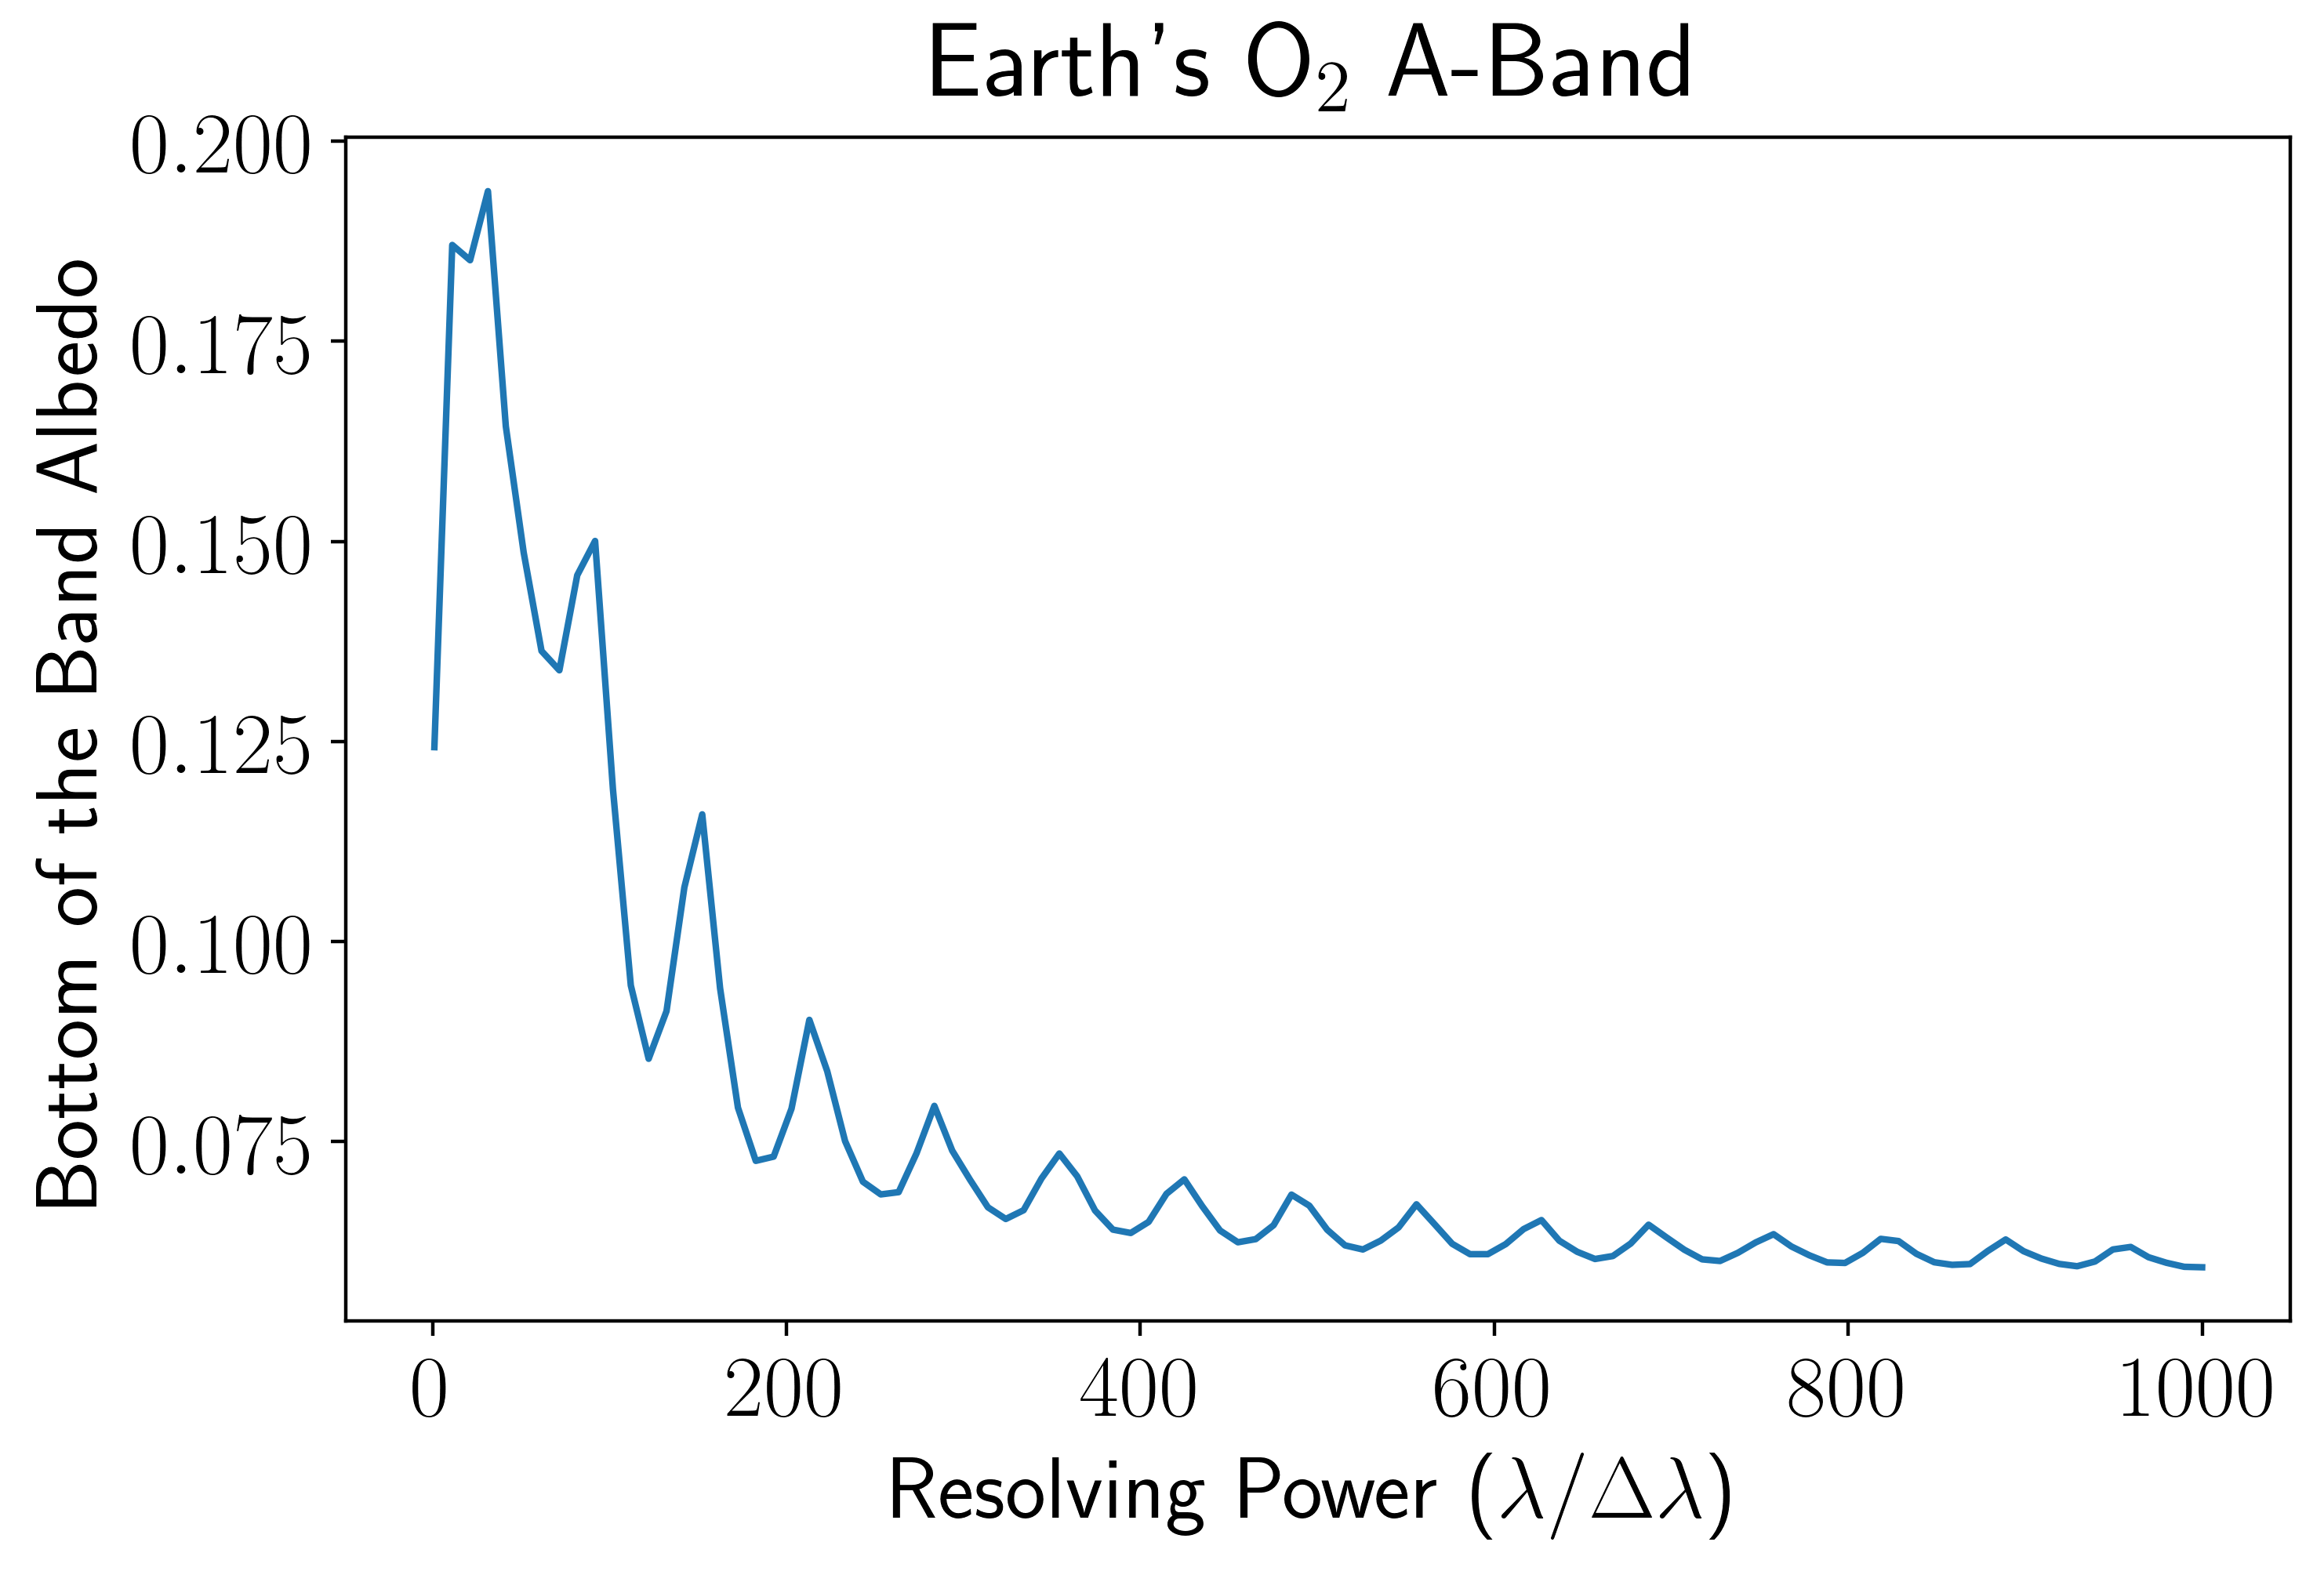

In [13]:
R = np.array(np.linspace(1,1000, 100))
bottom_val = np.zeros(len(R))

# Loop over R
for i, r in enumerate(R): 
    # Construct new low-res wavelength grid
    wl, dwl = cg.noise_routines.construct_lam(lammin, lammax, r)
    # Down-bin flux to low-res
    Alr = cg.downbin_spec(Ahr, lamhr, wl, dlam=dwl) 
    # Save bottom value
    bottom_val[i] = np.min(Alr)

plt.plot(R, bottom_val);
plt.xlabel(r"Resolving Power ($\lambda / \Delta \lambda$)")
plt.ylabel("Bottom of the Band Albedo")
plt.title(r"Earth's O$_2$ A-Band");